In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

torch.manual_seed(446)
np.random.seed(446)

## Pytorch tensor v.s. numpy array

In [2]:
a = np.array([1,2,3])
a

array([1, 2, 3])

In [3]:
b = torch.tensor([1,2,3])
b

tensor([1, 2, 3])

You can construct tensor from numpy using
```python
torch.from_numpy(numpy array)
```

In [4]:
torch.from_numpy(a)

tensor([1, 2, 3])

On the other hand, you can construct numpy array from tensor using,
```python
tensor.numpy()
```

In [5]:
b.numpy()

array([1, 2, 3])

You cannot add a tensor and a numpy array

In [6]:
a + b 

TypeError: unsupported operand type(s) for +: 'numpy.ndarray' and 'Tensor'

In [7]:
torch.from_numpy(a) + b #but if you change the np to tensor, you will be able to add them up

tensor([2, 4, 6])

In [8]:
a + b.numpy()

array([2, 4, 6])

Some functions in numpy are also useful in torch

In [9]:
np.linalg.norm(a) ##np.sqrt(1**2+2**2+3**2)

3.7416573867739413

In [10]:
torch.norm(b) 

RuntimeError: norm only supports floating-point dtypes

Oh no! Why do we get an error? Because they are not floaters!!!

In [11]:
b = torch.tensor([1.0, 2.0, 3.0])

In [12]:
torch.norm(b)

tensor(3.7417)

In [13]:
npx = np.array([[1,2],[3,4.]])
torchx = torch.tensor([[1,2],[3,4.]]) #add a dot to turn it to a matrix with floating number

In [15]:
np.mean(npx, axis = 1) #0 = by column, 1 = by row

array([1.5, 3.5])

In [16]:
#similarly, we have
torch.mean(torchx, dim=1)

tensor([1.5000, 3.5000])

## Tensor.view ~ np.reshape

In [18]:
N, C, W, H = 10000, 3, 28, 28
X = torch.randn((N, C, W, H))

In [22]:
X.shape

torch.Size([10000, 3, 28, 28])

In [23]:
X = X.view(N,C,-1) ##-1 is a trick for autofill!
X.shape

torch.Size([10000, 3, 784])

## Tensor Broadcasting
**rule**: Each tensor has at least one dimension.

When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

In [27]:
a = torch.empty(5,1,4,1)
b = torch.empty(3,1,1)
(a+b).shape

torch.Size([5, 3, 4, 1])

In [28]:
#an example of not broadcastable
a = torch.empty(5,1,4,1)
b = torch.empty(6,3,1,1)
(a+b).shape

RuntimeError: The size of tensor a (5) must match the size of tensor b (6) at non-singleton dimension 0

In [32]:
a = torch.empty(5,1,4,1)
b = torch.empty(5,1,1)
(a+b).shape

torch.Size([5, 5, 4, 1])

## Computational Graphs

In [33]:
a = torch.tensor(2.0, requires_grad=True) 
# we set requires_grad=True to let PyTorch know to keep the graph
b = torch.tensor(1.0, requires_grad=True)
c = a + b
d = b + 1
e = c * d
print('c', c)
print('d', d)
print('e', e)

c tensor(3., grad_fn=<AddBackward0>)
d tensor(2., grad_fn=<AddBackward0>)
e tensor(6., grad_fn=<MulBackward0>)


## Cuda Semantics

It's very easy to copy tensors from cpu to cuda and backwards.

In [ ]:
cpu = torch.device("cpu")
gpu = torch.device("cuda")

x = torch.rand(10)
print(x)
x = x.to(gpu)
print(x)
x = x.to(cpu)
print(x)

## Use pytorch to find gradients


Now that we have seen that PyTorch keeps the graph around for us, let's use it to compute some gradients for us.

Consider the function $f(x) = (x-2)^2$.

Q: Compute $\frac{d}{dx} f(x)$ and then compute $f'(1)$.

We make a `backward()` call on the leaf variable (`y`) in the computation, computing all the gradients of `y` at once.

In [42]:
def f(x):
    return (x-2)**2

def fp(x):
    return 2*(x-2) #this is the solution to the gradient of f(x)

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

print('Analytical f\'(x):', fp(x))
print('PyTorch\'s f\'(x):', x.grad)

Analytical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
PyTorch's f'(x): tensor([-2.])


It can also find gradients of functions.

Let $w = [w_1, w_2]^T$

Consider $g(w) = 2w_1w_2 + w_2\cos(w_1)$

Q: Compute $\nabla_w g(w)$ and verify $\nabla_w g([\pi,1]) = [2, \pi - 1]^T$

In [36]:
def g(w):
    return 2*w[0]*w[1] + w[1]*torch.cos(w[0])

def grad_g(w):
    return torch.tensor([2*w[1] - w[1]*torch.sin(w[0]), 2*w[0] + torch.cos(w[0])])

w = torch.tensor([np.pi, 1], requires_grad=True)

z = g(w)
z.backward()

print('Analytical grad g(w)', grad_g(w))
print('PyTorch\'s grad g(w)', w.grad)

Analytical grad g(w) tensor([2.0000, 5.2832])
PyTorch's grad g(w) tensor([2.0000, 5.2832])


## Gradient Descent
Let's consider the example above, what is the value of x that minimizes the function f?

The correct answer would be 2 since (2-2)^2 = 0. Let's use Gradient Descent to find this value.

In [55]:
x = torch.tensor([5.0], requires_grad = True) ## initialize with a random value

In [56]:
learning_rate =.25
print('iter,\tx,\tf(x),\tf\'(x),\tf\'(x) pytorch')
for i in range(15): #let's do 15 iterations
    y = f(x)
    y.backward()
    print('{},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f}'.format(i, x.item(), f(x).item(), fp(x).item(), x.grad.item()))
    x.data = x.data - learning_rate * x.grad
    x.grad.detach_()
    x.grad.zero_() #make sure you zero the gradient variable since the backward call accumulates the gradients

iter,	x,	f(x),	f'(x),	f'(x) pytorch
0,	5.000,	9.000,	6.000,	6.000
1,	3.500,	2.250,	3.000,	3.000
2,	2.750,	0.562,	1.500,	1.500
3,	2.375,	0.141,	0.750,	0.750
4,	2.188,	0.035,	0.375,	0.375
5,	2.094,	0.009,	0.188,	0.188
6,	2.047,	0.002,	0.094,	0.094
7,	2.023,	0.001,	0.047,	0.047
8,	2.012,	0.000,	0.023,	0.023
9,	2.006,	0.000,	0.012,	0.012
10,	2.003,	0.000,	0.006,	0.006
11,	2.001,	0.000,	0.003,	0.003
12,	2.001,	0.000,	0.001,	0.001
13,	2.000,	0.000,	0.001,	0.001
14,	2.000,	0.000,	0.000,	0.000


Yay! We found out that the optimal value of x that minimizes f(x) is 2.

## Linear Regression
Instead of minimizing the value of a function. Let's try gradient descent on a mock data to fit a linear regression model.

In [6]:
d = 2
n = 50
X = torch.randn(n,d)
true_w = torch.tensor([[-1.0], [2.0]])
y = X @ true_w + torch.randn(n,1) * 0.1
print('X shape', X.shape)
print('y shape', y.shape)
print('w shape', true_w.shape)

X shape torch.Size([50, 2])
y shape torch.Size([50, 1])
w shape torch.Size([2, 1])


**Note: dimensions**
PyTorch does a lot of operations on batches of data. The convention is to have your data be of size $(N, d)$ where $N$ is the size of the batch of data.

To verify PyTorch is computing the gradients correctly, let's recall the gradient for the RSS objective:

$$\nabla_w \mathcal{L}_{RSS}(w; X) = \nabla_w\frac{1}{n} ||y - Xw||_2^2 = -\frac{2}{n}X^T(y-Xw)$$

In [63]:
# define a linear model with no bias
def model(X, w):
    return X @ w

# the residual sum of squares loss function
def rss(y, y_hat):
    return torch.norm(y - y_hat)**2 / n

# analytical expression for the gradient
def grad_rss(X, y, w):
    return -2*X.t() @ (y - X @ w) / n

w = torch.tensor([[1.], [0]], requires_grad=True)
y_hat = model(X, w)

loss = rss(y, y_hat)
loss.backward()

print('Analytical gradient', grad_rss(X, y, w).detach().view(2).numpy())
print('PyTorch\'s gradient', w.grad.view(2).numpy())

Analytical gradient [ 4.342543  -3.5023162]
PyTorch's gradient [ 4.342543 -3.502316]


Pytorch does compute the gradient correctly.

Linear Regression with Gradient Descent using AutoGrad

In [64]:
learning_rate = 0.1
for i in range(20):
    y_hat = model(X, w)
    loss = rss(y, y_hat)
    loss.backward() ##always use the function you would like to minimize to backward()
    w.data = w.data - learning_rate * w.grad
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), w.view(2).detach().numpy()))
    w.grad.detach_()
    w.grad.zero_()

0,	7.82,	[0.13149136 0.70046324]
1,	2.84,	[-0.11822014  0.9229876 ]
2,	1.84,	[-0.31444427  1.1054724 ]
3,	1.19,	[-0.4684834  1.2552956]
4,	0.77,	[-0.58927345  1.3784461 ]
5,	0.50,	[-0.68387645  1.4797904 ]
6,	0.33,	[-0.75787055  1.563287  ]
7,	0.22,	[-0.8156596  1.632159 ]
8,	0.15,	[-0.86071837  1.6890337 ]
9,	0.10,	[-0.89578694  1.736055  ]
10,	0.07,	[-0.9230244  1.7749742]
11,	0.05,	[-0.94413096  1.8072236 ]
12,	0.03,	[-0.9604442  1.8339758]
13,	0.02,	[-0.9730157  1.8561921]
14,	0.02,	[-0.9826713  1.8746614]
15,	0.01,	[-0.99005884  1.8900318 ]
16,	0.01,	[-0.99568594  1.9028363 ]
17,	0.01,	[-0.99994993  1.913514  ]
18,	0.01,	[-1.0031612  1.9224268]
19,	0.01,	[-1.0055621  1.9298735]


In [66]:
true_w.view(2)

tensor([-1.,  2.])

**Another Example**

In [103]:
x = torch.ones(100,2)
x[:,0].uniform_(-1,1.)
x[:5]

tensor([[-0.2957,  1.0000],
        [ 0.1263,  1.0000],
        [-0.9388,  1.0000],
        [ 0.8926,  1.0000],
        [-0.2169,  1.0000]])

In [104]:
a = torch.tensor([3.,2]);a

tensor([3., 2.])

In [105]:
y = x@a + torch.rand(100)
y[:5]

tensor([ 1.4860,  2.5935, -0.4644,  5.3710,  1.9420])

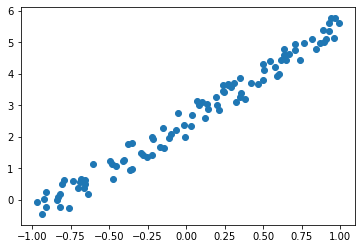

In [106]:
plt.scatter(x[:,0],y)

In [107]:
def mse(y_hat, y): return ((y_hat - y)**2).mean()

In [108]:
a = torch.tensor([-1, 1.])

In [109]:
y_hat = x @ a
mse(y_hat, y)

tensor(8.3516)

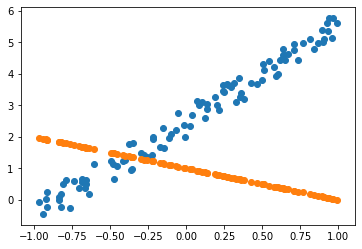

In [110]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_hat)

In [111]:
a = torch.nn.Parameter(a); a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [112]:
def update(lr):
    y_hat = x @ a
    loss = mse(y,y_hat)
    if t%10 ==0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr*a.grad)
        a.grad.zero_()


In [113]:
for t in range(100): update(lr=0.1)

tensor(8.3516, grad_fn=<MeanBackward0>)
tensor(1.3787, grad_fn=<MeanBackward0>)
tensor(0.3927, grad_fn=<MeanBackward0>)
tensor(0.1530, grad_fn=<MeanBackward0>)
tensor(0.0928, grad_fn=<MeanBackward0>)
tensor(0.0776, grad_fn=<MeanBackward0>)
tensor(0.0737, grad_fn=<MeanBackward0>)
tensor(0.0728, grad_fn=<MeanBackward0>)
tensor(0.0725, grad_fn=<MeanBackward0>)
tensor(0.0725, grad_fn=<MeanBackward0>)


In [118]:
y_hat = x@a

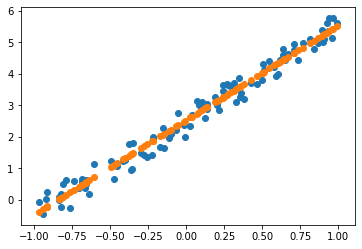

In [121]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_hat.detach_())

**Animate the whole process of gradient descent**

In [122]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [133]:
a = nn.Parameter(torch.tensor([-1,1.]))
fig=plt.figure()
plt.scatter(x[:,0],y,c='orange')
line, = plt.plot(x[:,0], y_hat)
plt.close()

In [ ]:
def animate(i):
    update(1e-1)
    line.set_ydata(x@a.detach())
    return line,

animation.FuncAnimation(fig, animate, np.arange(0,100),interval= 30)

In [144]:
a = nn.Parameter(torch.tensor([-1,1.]))
fig=plt.figure()
plt.scatter(x[:,0],y,c='orange')
line, = plt.plot(x[:,0], y_hat)
plt.close()

In [ ]:
def animate(i):
    update(1e-2) #using a slower learning rate this time
    line.set_ydata(x@a.detach())
    return line,

animation.FuncAnimation(fig, animate, np.arange(0,600),interval= 20)

## Torch.nn.Module

**Linear module**

The bread and butter of modules is the Linear module which does a linear transformation with a bias. It takes the input and output dimensions as parameters, and creates the weights in the object.

Unlike how we initialized our $w$ manually, the Linear module automatically initializes the weights randomly. For minimizing non convex loss functions (e.g. training neural networks), initialization is important and can affect results. If training isn't working as well as expected, one thing to try is manually initializing the weights to something different from the default. PyTorch implements some common initializations in `torch.nn.init`.

[`torch.nn.init` docs](https://pytorch.org/docs/stable/nn.html#torch-nn-init)

In [146]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)

example_tensor = torch.tensor([[1.,2,3], [4,5,6]])
# applys a linear transformation to the data
transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transormed', transformed.shape)
print()
print('We can see that the weights exist in the background\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([2, 3])
transormed torch.Size([2, 4])

We can see that the weights exist in the background

W: Parameter containing:
tensor([[ 0.5081,  0.1194, -0.0141],
        [-0.0090, -0.3841, -0.1353],
        [-0.3324, -0.2149,  0.1152],
        [ 0.0236,  0.1119,  0.0302]], requires_grad=True)
b: Parameter containing:
tensor([ 0.3030, -0.5704, -0.4895,  0.5599], requires_grad=True)


**Activation Function**

In [147]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
#We also have Sigmoid, Tanh
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([0., 1., 0.])


**Sequential**

In [148]:
d_in = 3
d_hidden = 4
d_out = 1
model = torch.nn.Sequential(
                            nn.Linear(d_in, d_hidden),
                            nn.Tanh(),
                            nn.Linear(d_hidden, d_out),
                            nn.Sigmoid()
                           )

example_tensor = torch.tensor([[1.,2,3],[4,5,6]])
transformed = model(example_tensor)
print('transformed', transformed.shape)

transformed torch.Size([2, 1])


In [149]:
params = model.parameters()

for param in params:
    print(param)

Parameter containing:
tensor([[ 0.5316, -0.2768,  0.4629],
        [-0.0905, -0.1957,  0.4242],
        [-0.2548, -0.4407, -0.3990],
        [-0.4644, -0.1361,  0.1039]], requires_grad=True)
Parameter containing:
tensor([-0.2420,  0.3804,  0.4228, -0.4247], requires_grad=True)
Parameter containing:
tensor([[-0.2815,  0.2431,  0.3258, -0.2328]], requires_grad=True)
Parameter containing:
tensor([0.1538], requires_grad=True)


**Loss Function**

In [150]:
mse_loss_fn = nn.MSELoss()

input = torch.tensor([[0., 0, 0]])
target = torch.tensor([[1., 0, -1]])

loss = mse_loss_fn(input, target)

print(loss)

tensor(0.6667)


## Torch.optim 
optimizer

In [173]:
model = nn.Linear(1,1)
# create a simple dataset
X_simple = torch.tensor([[1.]])
y_simple = torch.tensor([[2.]])

# create our optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-1)
mse_loss_fn = nn.MSELoss()

y_hat = model(X_simple)
print('model params before:', model.weight)
loss = mse_loss_fn(y_hat, y_simple)
optim.zero_grad()
loss.backward()
optim.step()
print('model params after:', model.weight)


model params before: Parameter containing:
tensor([[-0.8100]], requires_grad=True)
model params after: Parameter containing:
tensor([[-0.2944]], requires_grad=True)


## Example: LR using GD in a pytorchic way

In [4]:
learning_rate = 0.1

linear_module = nn.Linear(2, 1, bias=False)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(linear_module.parameters(), lr=learning_rate)

print('iter,\tloss,\tw')

for i in range(20):
    y_hat = linear_module(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	7.78,	[ 0.05598211 -0.13814455]
1,	5.19,	[-0.12705827  0.25760278]
2,	3.47,	[-0.27805662  0.5800568 ]
3,	2.31,	[-0.40263495  0.8427856 ]
4,	1.55,	[-0.5054265  1.0568465]
5,	1.03,	[-0.59025025  1.2312506 ]
6,	0.69,	[-0.66025406  1.3733413 ]
7,	0.46,	[-0.71803313  1.4891027 ]
8,	0.31,	[-0.76572716  1.5834112 ]
9,	0.21,	[-0.80510044  1.6602405 ]
10,	0.14,	[-0.83760786  1.7228285 ]
11,	0.10,	[-0.86444944  1.7738136 ]
12,	0.07,	[-0.8866149  1.8153456]
13,	0.05,	[-0.90492076  1.8491764 ]
14,	0.03,	[-0.92004055  1.8767331 ]
15,	0.03,	[-0.93253005  1.8991785 ]
16,	0.02,	[-0.9428478  1.9174602]
17,	0.02,	[-0.9513723  1.9323502]
18,	0.01,	[-0.958416   1.9444772]
19,	0.01,	[-0.96423656  1.9543537 ]

true w		 [-1.  2.]
estimated w	 [-0.96423656  1.9543537 ]


## Example: Linear Regression using SGD

In [7]:
step_size = 0.01

linear_module = nn.Linear(2, 1)
loss_func = nn.MSELoss()
optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)
print('iter,\tloss,\tw')
for i in range(200):
    rand_idx = np.random.choice(n) # take a random point from the dataset
    x = X[rand_idx] 
    y_hat = linear_module(x)
    loss = loss_func(y_hat, y[rand_idx]) # only compute the loss on the single point
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 20 == 0:
        print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	0.23,	[-0.6309034  -0.52551126]
20,	3.44,	[-0.943673    0.22195444]
40,	0.68,	[-0.83991414  0.9894573 ]
60,	0.24,	[-0.97053766  1.2711158 ]
80,	0.13,	[-1.009253   1.5601454]
100,	0.08,	[-1.0291986  1.6845057]
120,	0.02,	[-1.02208    1.8423105]
140,	0.00,	[-1.038649   1.9005076]
160,	0.00,	[-1.0496646  1.9212244]
180,	0.02,	[-1.0362965  1.9647309]

true w		 [-1.  2.]
estimated w	 [-1.0421957  1.9816858]


## Neural Network Example

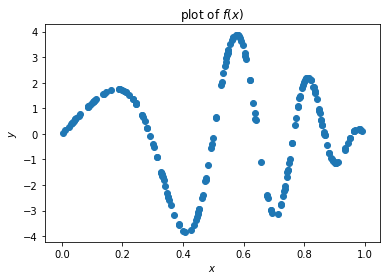

In [21]:
%matplotlib inline

d = 1
n = 200
X = torch.rand(n,d)
y = 4 * torch.sin(np.pi * X) * torch.cos(6*np.pi*X**2)

plt.scatter(X.numpy(), y.numpy())
plt.title('plot of $f(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

In [67]:
# feel free to play with these parameters

step_size = 0.1
n_epochs = 6000
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(),
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))




iter,	loss
0,	4.17
600,	2.78
1200,	1.21
1800,	0.69
2400,	0.37
3000,	0.17
3600,	0.13
4200,	0.12
4800,	0.09
5400,	0.07


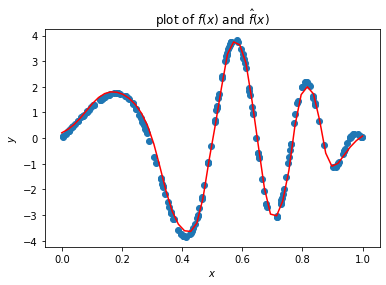

In [68]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

**We can animate the whole processes**

In [20]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [54]:
d = 1
n = 200
X = torch.rand(n,d)
y = 4 * torch.sin(np.pi * X) * torch.cos(6*np.pi*X**2)

In [63]:
step_size = 0.08
n_epochs = 6000
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(),
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()


In [64]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
fig = plt.figure()
plt.scatter(X.numpy(), y.numpy(), c='orange')
line, = plt.plot(X_grid.numpy(), y_hat.detach().numpy())
plt.close()

In [65]:
def update():
    optim = torch.optim.SGD(neural_network.parameters(), lr=step_size)
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))

In [ ]:
def animate(i):
    update()
    line.set_ydata(neural_network(X_grid).detach().numpy())
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 6000), interval=20)

## Momentum
If we introduce momentum, we can get the error to very low pretty easily.

In [69]:
# feel free to play with these parameters

step_size = 0.05
momentum = 0.9
n_epochs = 1500
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(),
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))


iter,	loss
0,	4.08
150,	2.89
300,	0.42
450,	0.09
600,	0.07
750,	0.04
900,	0.02
1050,	0.10
1200,	0.01
1350,	0.00


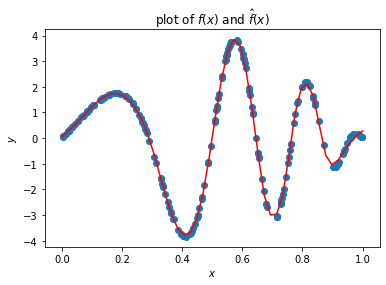

In [70]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()